In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sparsecoding import inference
from sparsecoding import models
from sparsecoding.data.datasets import field
from sparsecoding.visualization import plot_dictionary

### Define constants and load data

In [3]:
# Enter path of the Field dataset. If it does not exist, it will be downloaded.
data_path = "./"
n_samples = 100
patch_size = 16
n_features = patch_size**2
images = field.FieldDataset(patch_size=patch_size, root=data_path)

# Get n_samples, reshape to 2D, and cast to torch.float32.
data = images[:n_samples].reshape(n_samples, -1).to(torch.float32)
print(data.shape)

torch.Size([100, 256])


### Visualize patches

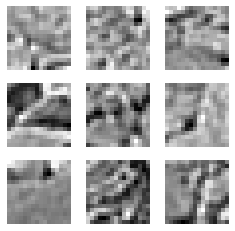

In [5]:
figure = plt.figure(figsize=(4,4))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img = (data[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().reshape([patch_size, patch_size]), cmap="gray")
plt.show()

### Sparse Coding via Dictionary Learning

In [6]:
### DEFINE MODEL
lca = inference.LCA(coeff_lr=1e-3,threshold=0.1,n_iter=300)
sc = models.SparseCoding(inference_method=lca,n_basis=n_features,n_features=n_features,dictionary_lr=1e-1)

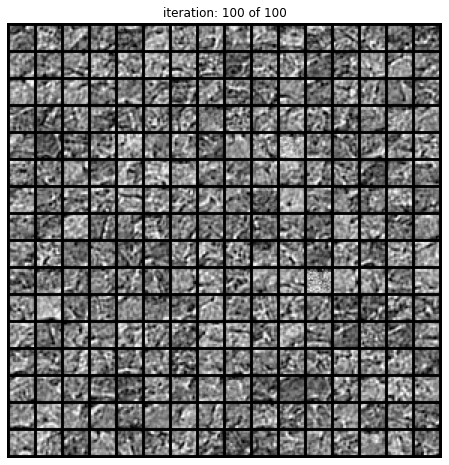

In [7]:
n_epoch = 100
montage_update_rate = 10

# Plot Updates
nrow = 16
fig,ax = plot_dictionary(sc.dictionary,nrow=nrow)

losses = np.array([])

for i in range(n_epoch//montage_update_rate):
    # learn dictionary
    loss = sc.learn_dictionary(dataset=data,n_epoch=n_epoch,batch_size=500)
    losses = np.concatenate([losses,loss])
    # update montage
    fig,ax = plot_dictionary(sc.dictionary,fig=fig,ax=ax,title='iteration: %d of %d'%(i*montage_update_rate,n_epoch),nrow=nrow)

fig,ax = plot_dictionary(sc.dictionary,fig=fig,ax=ax,title='iteration: %d of %d'%(n_epoch,n_epoch),nrow=nrow)

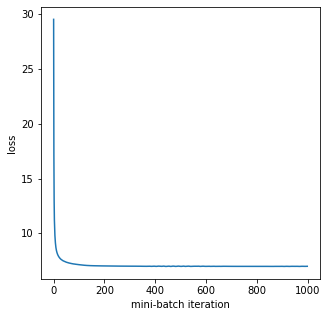

In [8]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(losses)
ax.set_xlabel('mini-batch iteration')
ax.set_ylabel('loss')
plt.show()